In [1]:
import manim as mn

from rc_lib import style
from rc_lib.math_utils import vector
from rc_lib.view_utils import title_sequence
from rc_lib.common_mobjects import plate, sketch

Manim Community v0.17.2

In [2]:
quality = "m" # l or m

In [3]:
inner_color = style.GREEN
boundary_color = style.BLUE
factory = plate.PlateCircleFactory()
factory.set_inner_color(inner_color).set_outer_color(boundary_color)

title = title_sequence.TitleSequence(default_color=boundary_color)

In [4]:
%%manim -v CRITICAL --format mp4 --disable_caching -q$quality -o plate IntakePlateScene

class IntakePlateScene(mn.Scene):
    def setup(self):
        small_base = factory.make_generator(0.15, 0.2)
        medium_base = factory.make_generator(0.4, 0.2)

        front_hole = vector.point_2d(-4, -3)
        middle_hole = vector.point_2d(-1.5, 0.25)
        back_hole = vector.point_2d(2.5, 1.5)
        back_offset = vector.point_2d(0.8, 0.75)

        points = [
            medium_base(front_hole),
            medium_base(middle_hole),
            medium_base(back_hole),
            small_base(back_hole + back_offset),
            small_base(back_hole + vector.point_2d(1, -0.2)),
            small_base((middle_hole + back_hole) / 2),
            small_base((front_hole + middle_hole) / 2)
        ]
        boundary_order = [1, 3, 4, 0]
        self._plate_group = plate.PlateGroup(points, boundary_order, boundary_color=boundary_color)
        title.reset()

    def construct(self):
        self.play(title.next("Draw plate holes", color=inner_color))
        self.play(self._plate_group.draw_inner_circles(lag_ratio=0.5))

        self.play(title.next("Add larger circles"))
        self.play(self._plate_group.draw_outer_circles(lag_ratio=0.5))

        self.play(title.next("Connect boundary"))
        self.play(self._plate_group.draw_boundary(lag_ratio=0.75, run_time=5))

        # self.play(title.next("Trim", color=boundary_color))
        # self.play(plate_group.trim(), run_time=5)

        self.wait(style.END_DELAY)

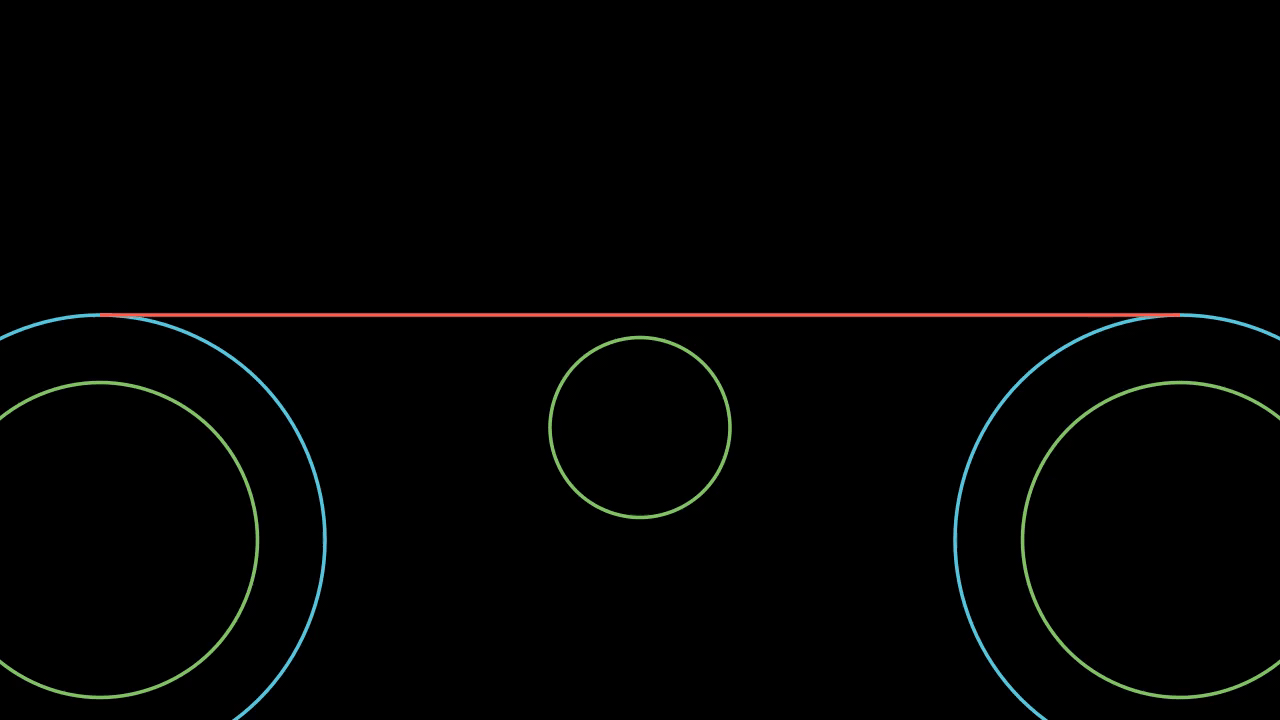

In [5]:
%%manim -v CRITICAL --format gif --disable_caching -q$quality -o boundary_redraw BoundaryRedrawScene

class BoundaryRedrawScene(mn.Scene):
    def setup(self):
        generator = factory.make_generator(1.75, 0.75)
        self._left = generator(vector.point_2d(-6, -2))
        self._right = generator(vector.point_2d(6, -2))
        self._middle = factory.make(1, 0.75, vector.point_2d(0, -0.75))

        self._line = plate.plate_circle_tangent_line(self._left, self._right, style.RED)
        self.add(self._left, self._right, self._line, self._middle.inner_circle)

        title.reset()

    def construct(self):
        self.play(title.next("Add outer circle"))
        self.play(mn.GrowFromCenter(self._middle.outer_circle))

        self.play(title.next("Redraw boundary"))
        self.play(mn.Uncreate(self._line))
        self.wait(0.25)
        self.play(mn.Create(plate.plate_circle_tangent_line(self._left, self._middle, boundary_color)))
        self.play(mn.Create(plate.plate_circle_tangent_line(self._middle, self._right, boundary_color)))

        self.wait(style.END_DELAY)

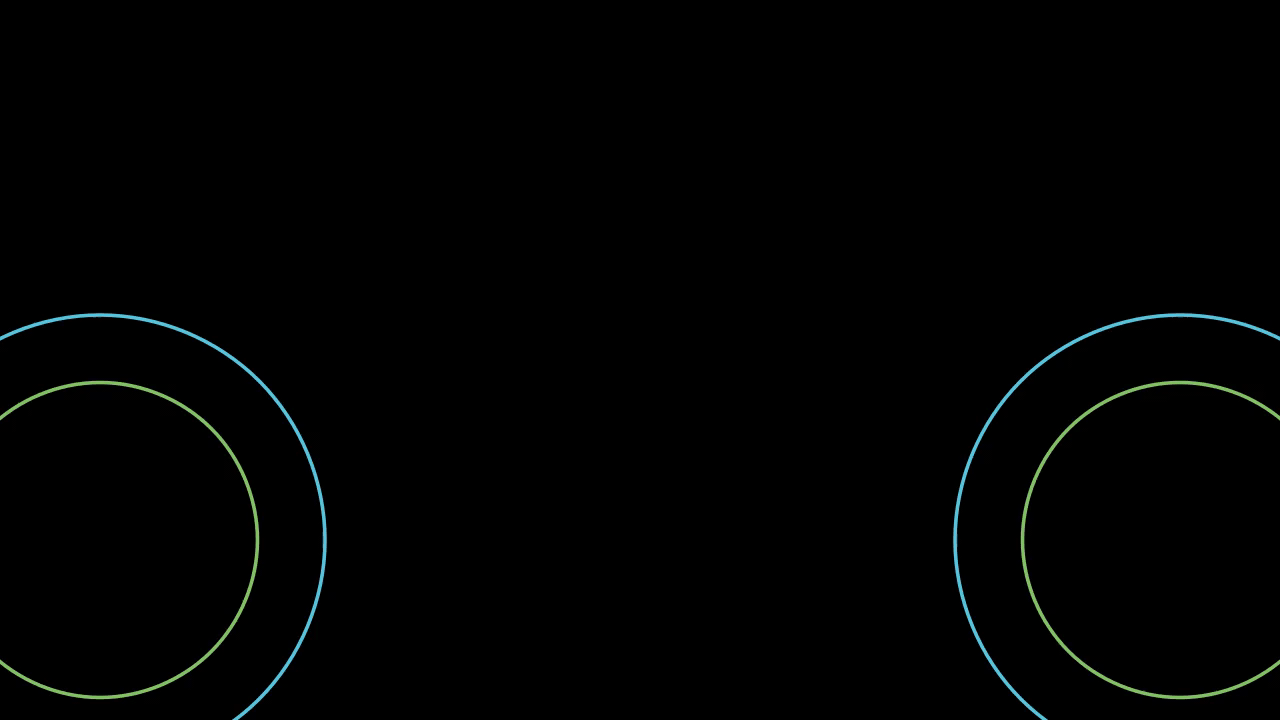

In [6]:
%%manim -v CRITICAL --format gif --disable_caching -q$quality -o boundary_constraints BoundaryConstraintScene
import operator

class BoundaryConstraintScene(mn.Scene):
    def setup(self):
        generator = factory.make_generator(1.75, 0.75)
        self._left = generator(vector.point_2d(-6, -2))
        self._right = generator(vector.point_2d(6, -2))
        self.add(self._left, self._right)

        self._tangent_points = plate.plate_circle_tangent_points(self._left, self._right)

        left_start_point = self._tangent_points[0] + vector.point_2d(1.75, 0.75)
        right_start_point = self._tangent_points[1] + vector.point_2d(-2, 0.5)
        self._line = sketch.SketchLine(left_start_point, right_start_point, color=boundary_color)

        title.reset()
    
    def get_vars(self, line_end: sketch.LineEnd, *keys: str):
        return [self._get_var(line_end, key) for key in keys]

    def _get_var(self, line_end: sketch.LineEnd, key: str):
        if (key == "tangent_point"):
            return self._tangent_points[line_end]

        attributes = {
            "circle" : ("_left", "_right"),
            "tip" : ("_line.start", "_line.end"),
            "point" : ("_line.start_point", "_line.end_point"),
        }
        result = operator.attrgetter(attributes[key][line_end])(self)
        return result() if key == "point" else result

    def construct(self):
        self.play(title.next("Create line"))
        self.play(self._line.draw())

        self.play(title.next("Add coincident constraints"))
        self.do_coincident_move(sketch.LineEnd.START)
        self.do_coincident_move(sketch.LineEnd.END)

        self.play(title.next("Add tangent constraints"))
        self.do_tangent_move(sketch.LineEnd.START)
        self.do_tangent_move(sketch.LineEnd.END)

        self.wait(style.END_DELAY)
    
    def do_coincident_move(self, line_end: sketch.LineEnd):
        self._do_flash(line_end)
        new_point = self._coincident_point(line_end)
        self.play(mn.Transform(self._line, self._line.copy().set_position(new_point, line_end)))

    def _coincident_point(self, line_end: sketch.LineEnd) -> vector.Point2d:
        circle, point = self.get_vars(line_end, "circle", "point")
        return circle.center() + vector.normalize(point - circle.center()) * circle.outer_radius()
    
    def do_tangent_move(self, line_end: sketch.LineEnd):
        self._do_flash(line_end)
        circle, tangent_point = self.get_vars(line_end, "circle", "tangent_point")
        angle = self._tangent_angle(line_end)
        self.play(mn.Transform(self._line, self._line.copy().set_position(tangent_point, line_end),
            path_arc=angle, part_arg_centers=[circle.center()]))

    def _tangent_angle(self, line_end: sketch.LineEnd) -> float:
        point, tangent_point, circle = self.get_vars(line_end, "point", "tangent_point", "circle")
        return (1 if line_end == sketch.LineEnd.START else -1) * mn.angle_between_vectors(point - circle.center(), tangent_point - circle.center())
    
    def _do_flash(self, line_end: sketch.LineEnd):
        circle, tip = self.get_vars(line_end, "circle", "tip")
        self.play(mn.Flash(tip, run_time=0.75))
        self.play(mn.Flash(circle, flash_radius=circle.outer_radius(), num_lines=40, run_time=0.75))